In [ ]:
from pathlib import Path
import torch.multiprocessing as mp
from fnn.data import load_training_data
from fnn.microns.build import network
from fnn.microns import load_network_from_params
from fnn.train.schedulers import CosineLr
from fnn.train.optimizers import SgdClip
from fnn.train.loaders import Batches
from fnn.train.objectives import NetworkLoss
from fnn import microns
from fnn.utils import logging
import torch
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import polars as pl
import rerun as rr
import torchinfo
import sklearn.decomposition
import sklearn.manifold
import scipy.signal

# Downloaded data paths

In [201]:

# training/evaluation data for this session. Note: all the data is uploaded but this data is
# already upsampled and ready for training/evaluation.
session=4
scan_idx=7

# Trained model parameters
src_dir = "/groups/saalfeld/saalfeldlab/vijay/fnn/data/microns_digital_twin/params"

# Training data
training_data_dir = f"/groups/saalfeld/saalfeldlab/vijay/fnn/training_data_27203_{session}_{scan_idx}"

# Evaluation data
evaluation_data_dir = Path(f"/groups/saalfeld/saalfeldlab/vijay/fnn/evaluation_data_27203_{session}_{scan_idx}")

unit_anatomy_path = "/groups/saalfeld/saalfeldlab/vijay/fnn/data/microns_digital_twin/properties/anatomy/units.csv"

In [202]:
unit_anatomy_df = pl.read_csv(unit_anatomy_path).filter(pl.col("session") == session).filter(
    pl.col("scan_idx") == scan_idx
)
print(unit_anatomy_df.shape)
unit_anatomy_df["brain_area"]

(7493, 8)


brain_area
str
"""LM"""
"""LM"""
"""LM"""
"""LM"""
"""LM"""
…
"""V1"""
"""V1"""
"""V1"""


# Training data

In [203]:
max_items = None
dataset = load_training_data(training_data_dir, max_items=max_items)


Loading units: 100%|██████████| 477/477 [00:22<00:00, 20.91it/s]
/home/kumarv4@hhmi.org/repos/fnn/fnn/data/dataset.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(dataframe[item][0], Item), f"{dataframe[item][0]} is not an instance of Item"


In [204]:
# dataset is a custom object that wraps a dataframe 
dataset.df.head()

,training,samples,stimuli,perspectives,modulations,units
trial_id,,,,,,
trial0,True,300,<fnn.data.dataset.NpyFile object at 0x7894902c...,<fnn.data.dataset.NpyFile object at 0x7892061d...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x78920593...
trial1,True,300,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892061d...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x78920593...
trial10,True,300,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892061d...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x78920593...
trial100,True,300,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892061d...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x78920593...
trial101,True,300,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892061d...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x78920593...


In [205]:
# Load the model and initialize weights
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [206]:
model, unit_map = microns.scan(
    session=session, 
    scan_idx=scan_idx, 
    directory=src_dir,
)
model = model.to(device)

In [207]:
torchinfo.summary(model, depth=2)

Layer (type:depth-idx)                                  Param #
Visual                                                  --
├─FeedforwardRecurrent: 1-1                             --
│    └─InputDense: 2-1                                  1,908,224
│    └─CvtLstm: 2-2                                     2,620,416
├─MlpMonitorRetina: 1-2                                 --
│    └─Plane: 2-3                                       12
│    └─StaticPower: 2-4                                 --
│    └─Angular: 2-5                                     --
│    └─SigmoidPower: 2-6                                3
│    └─Mlp: 2-7                                         678
├─MlpLstm: 1-3                                          --
│    └─Mlp: 2-8                                         192
│    └─Lstm: 2-9                                        8,704
├─PositionFeature: 1-4                                  --
│    └─Gaussian: 2-10                                   44,958
│    └─Tanh: 2-11            

In [208]:
# # Pick a stimulus
# stimuli = np.concatenate([x[:] for x in dataset.df.stimuli], axis=0)
# perspectives = np.concatenate([x[:] for x in dataset.df.perspectives], axis=0)
# modulations = np.concatenate([x[:] for x in dataset.df.modulations], axis=0)

# with torch.no_grad():
#     res = model.to_tensor(stimuli, perspectives, modulations)
#     exported = torch.export.export(model, res[:3])

# Run model

In [209]:
# Pick a stimulus
index = 10
stimuli = dataset.df.stimuli.iloc[index][:]
perspectives = dataset.df.perspectives.iloc[index][:]
modulations = dataset.df.modulations.iloc[index][:]
units = dataset.df.units.iloc[index][:]

In [210]:
# predict
pred = model.predict(stimuli, perspectives, modulations)

In [211]:
# We have 8509 units measured. But the network only predicts 7493 units. 
# We seem to only be making predictions for a subset of units & this is captured by unit_map
pred.shape, unit_map.shape, units.shape

((300, 7493), (7493, 3), (300, 8509))

In [212]:
dataset.df

,training,samples,stimuli,perspectives,modulations,units
trial_id,,,,,,
trial0,True,300,<fnn.data.dataset.NpyFile object at 0x7894902c...,<fnn.data.dataset.NpyFile object at 0x7892061d...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x78920593...
trial1,True,300,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892061d...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x78920593...
trial10,True,300,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892061d...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x78920593...
trial100,True,300,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892061d...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x78920593...
trial101,True,300,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892061d...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x78920593...
...,...,...,...,...,...,...
trial95,True,300,<fnn.data.dataset.NpyFile object at 0x78920593...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892059a...,<fnn.data.dataset.NpyFile object at 0x7892059d...
trial96,True,300,<fnn.data.dataset.NpyFile object at 0x78920593...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892059a...,<fnn.data.dataset.NpyFile object at 0x7892059d...
trial97,True,300,<fnn.data.dataset.NpyFile object at 0x78920593...,<fnn.data.dataset.NpyFile object at 0x78920597...,<fnn.data.dataset.NpyFile object at 0x7892059a...,<fnn.data.dataset.NpyFile object at 0x7892059d...


In [213]:
# readout id is the index of the readout unit that the network predicts
# unit_id maps you to the experimentally measured unit
assert (unit_map.index == np.arange(unit_map.shape[0])).all()
unit_gt = units[:, unit_map["unit_id"]]

Text(0, 0.5, 'Neurons')

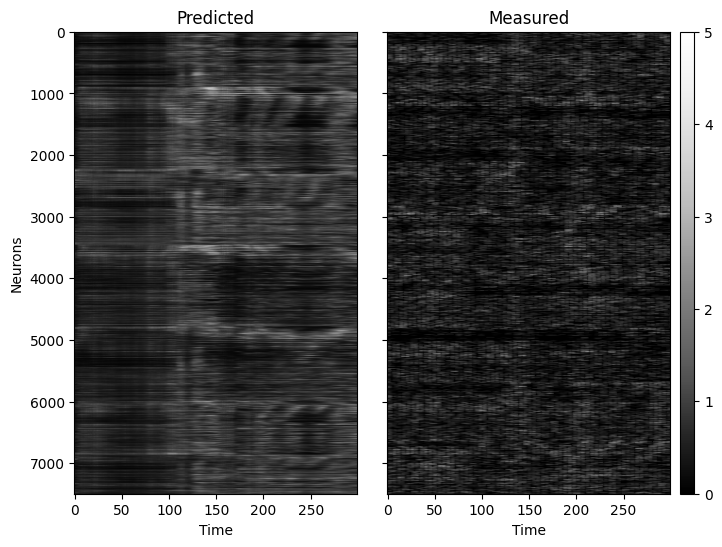

In [214]:

# Create a figure
fig = plt.figure(figsize=(8, 6))

# Create an ImageGrid with a single colorbar for the entire grid
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),
                 axes_pad=0.3,
                 aspect=False,
                 share_all=True,  # share x and y axes between all subplots
                 cbar_mode="single",  # use a single colorbar for the grid
                 cbar_location="right",
                 cbar_pad=0.1,
                 )
ax = grid.axes_all
ax[0].imshow(pred.T, aspect="auto", vmax=5, cmap="Grays_r")
ax[0].set_title("Predicted")
im = ax[1].imshow(unit_gt.T, aspect="auto", vmax=5, cmap="Grays_r")
ax[1].set_title("Measured")
grid.cbar_axes[0].colorbar(im)
ax[0].set_xlabel("Time")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Neurons")


Text(0, 0.5, 'Averaged signal over neurons')

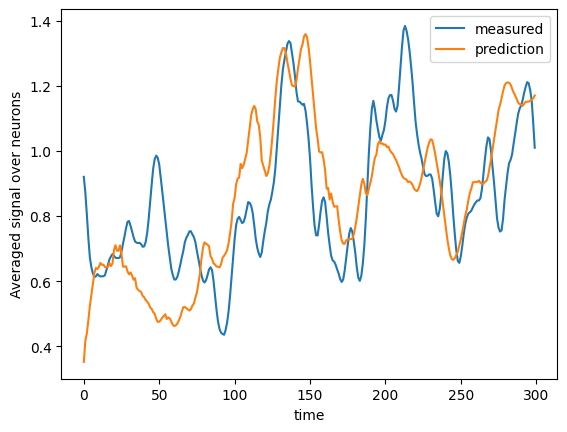

In [215]:
plt.plot(unit_gt.mean(1), label="measured")
plt.plot(pred.mean(1), label="prediction")
plt.legend()
plt.xlabel("time")
plt.ylabel("Averaged signal over neurons")

In [218]:
nsamples = int(300*6.3/30)

unit_gt_ds = scipy.signal.decimate(unit_gt, q=5, axis=0)
pred_ds = scipy.signal.decimate(pred, q=5, axis=0)

Text(0, 0.5, 'Neurons')

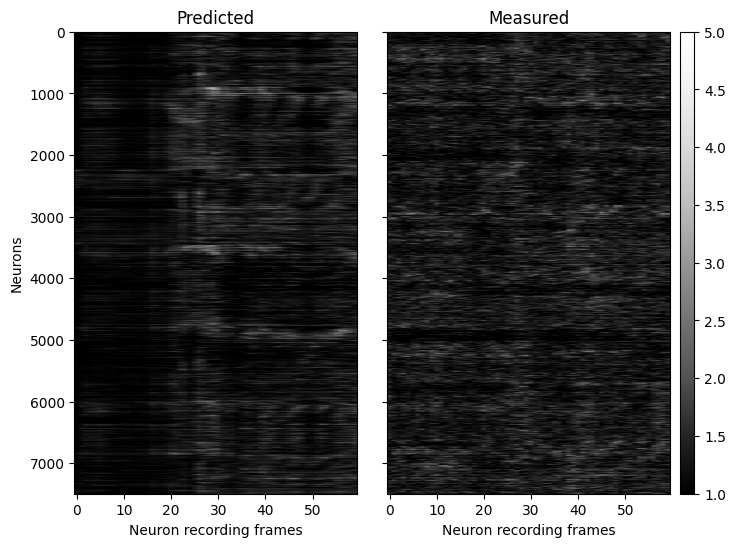

In [219]:

# Create a figure
fig = plt.figure(figsize=(8, 6))

# Create an ImageGrid with a single colorbar for the entire grid
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),
                 axes_pad=0.3,
                 aspect=False,
                 share_all=True,  # share x and y axes between all subplots
                 cbar_mode="single",  # use a single colorbar for the grid
                 cbar_location="right",
                 cbar_pad=0.1,
                 )
ax = grid.axes_all
ax[0].imshow(pred_ds.T, aspect="auto", vmin=1, vmax=5, cmap="Grays_r")
ax[0].set_title("Predicted")
im = ax[1].imshow(unit_gt_ds.T, aspect="auto", vmin=1, vmax=5, cmap="Grays_r")
ax[1].set_title("Measured")
grid.cbar_axes[0].colorbar(im)
ax[0].set_xlabel("Neuron recording frames")
ax[1].set_xlabel("Neuron recording frames")
ax[0].set_ylabel("Neurons")


Text(0, 0.5, 'Averaged signal over neurons')

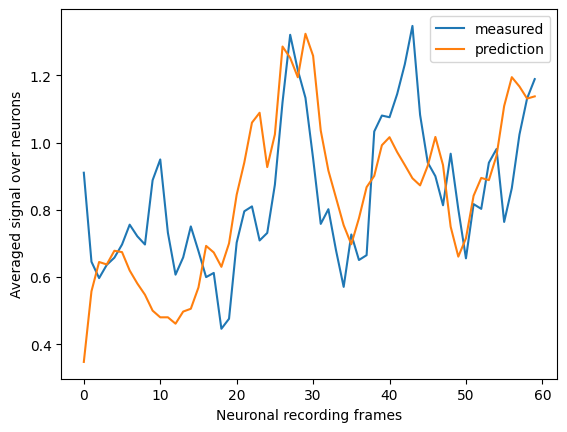

In [220]:
plt.plot(unit_gt_ds.mean(1), label="measured")
plt.plot(pred_ds.mean(1), label="prediction")
plt.legend()
plt.xlabel("Neuronal recording frames")
plt.ylabel("Averaged signal over neurons")

Text(0, 0.5, 'Ca measurement')

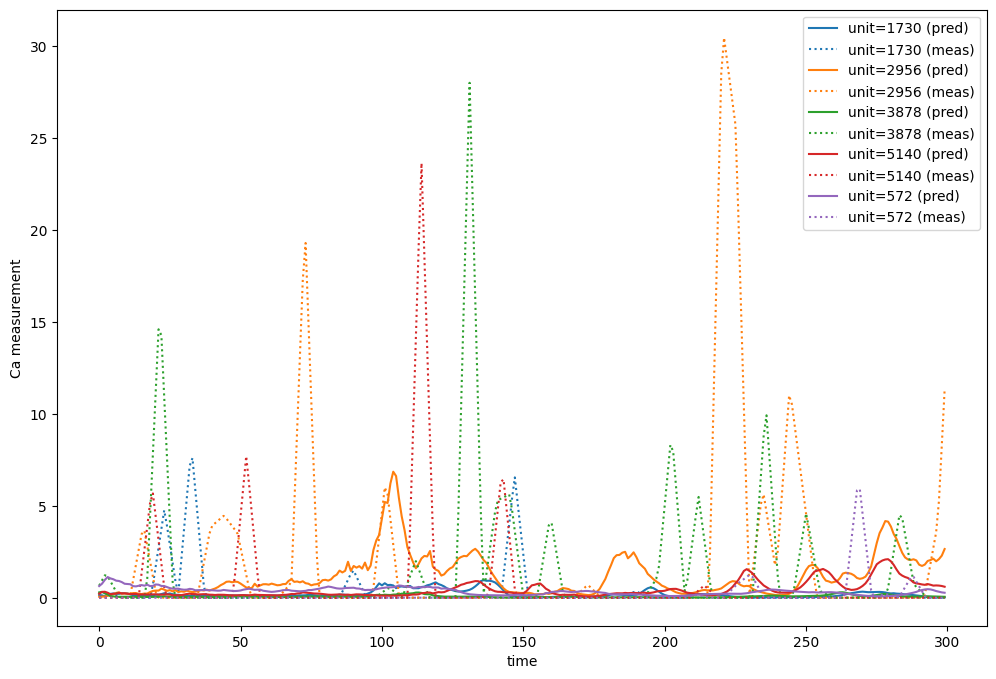

In [221]:
# 5 random neurons
# np.random.seed(0)
idxs = np.random.randint(0, 7493, size=5)
plt.figure(figsize=(12, 8))
for i in idxs:
    p = plt.plot(pred[:, i], label=f"unit={i} (pred)")
    plt.plot(unit_gt[:, i], ls="dotted", label=f"unit={i} (meas)", c = p[-1].get_color())
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("time")
plt.ylabel("Ca measurement")

Text(0.5, 0, 'Max signal over time/mean signal over time')

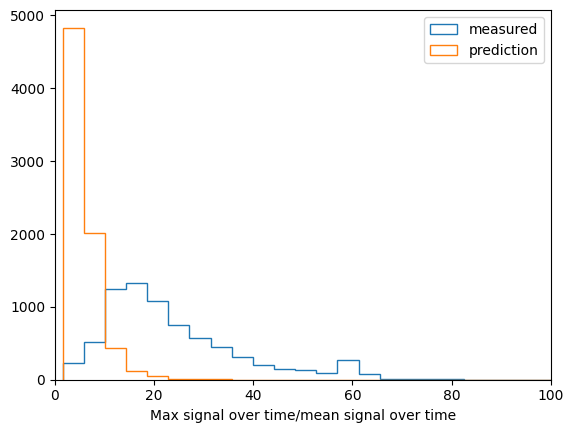

In [222]:
res = plt.hist(np.sort(unit_gt.max(0) / np.mean(unit_gt, axis=0)), bins=70, histtype="step", label="measured")
plt.hist(np.sort(pred.max(0) / np.mean(pred, axis=0)), bins=res[1], histtype="step", label="prediction")
plt.legend()
plt.xlim(0, 100)
plt.xlabel("Max signal over time/mean signal over time")

# Evaluation data (repeat stimuli)

In [223]:
from fnn.data import load_evaluation_data
from fnn import evaluate
from pathlib import Path


evaluation_data = load_evaluation_data(evaluation_data_dir)

Subdirectories: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


In [224]:
model, unit_map = microns.scan(
    session=session, 
    scan_idx=scan_idx, 
    directory=src_dir,
)
model = model.to(device)

In [225]:
evaluation_data.keys()

dict_keys(['modulations', 'perspectives', 'stimuli', 'units'])

In [226]:
from tqdm import tqdm

In [227]:
s = evaluation_data['stimuli']
p = evaluation_data['perspectives']
m = evaluation_data['modulations']

units_pred = []
for i in tqdm(range(len(s)), desc="Stimuli"):
    repeats_pred = []
    for j in range(len(s[i])):
        repeats_pred.append(
            model.predict(
                stimuli=s[i][j],
                perspectives=p[i][j],
                modulations=m[i][j]
            )
        )
    units_pred.append(repeats_pred)

Stimuli: 100%|██████████| 6/6 [03:11<00:00, 31.87s/it]


In [228]:
units_pred = np.array(units_pred)

In [229]:
# videos x repeat trials x time x neurons
units_pred.shape

(6, 10, 300, 7493)

In [230]:
units_meas = np.array(evaluation_data['units'])
units_meas.shape

(6, 10, 300, 8509)

1.0 3.4444050788879395
1.0 6.805554389953613
1.0 1.7250654697418213
1.0 9.919906616210938
1.0 4.851137638092041
1.0 6.263072490692139
1.0 9.411776542663574
1.0 10.287107467651367
1.0 7.950464725494385
1.0 7.2584004402160645


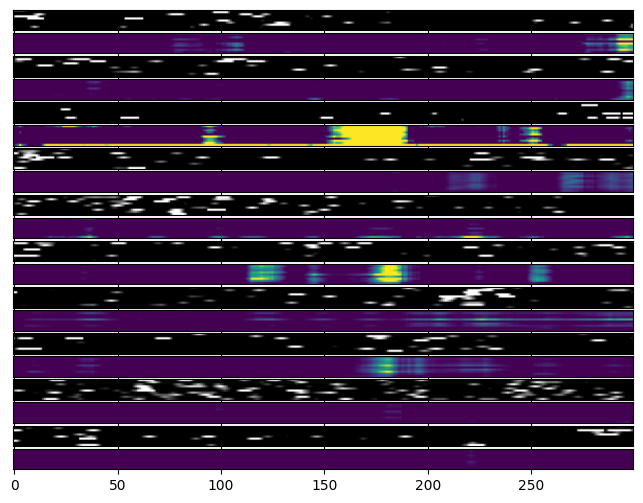

In [231]:

# Create a figure
fig = plt.figure(figsize=(8, 6))

# Create an ImageGrid with a single colorbar for the entire grid
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(20, 1),
                 axes_pad=(0., 0.),
                 aspect=False,
                 share_all=True,  # share x and y axes between all subplots
                #  cbar_mode="single",  # use a single colorbar for the grid
                #  cbar_location="right",
                #  cbar_pad=0.1,
                 )
ax = grid.axes_all
np.random.seed(123)
ixs =np.random.choice(7493, size=10)
for i, ix in enumerate(ixs):
    umeas = units_meas[0, :, :, ix]
    upred = units_pred[0, :, :, ix]
    vmax = np.percentile(umeas, 98)
    im = ax[2*i].imshow(umeas, vmin=1, vmax=vmax, cmap="Greys_r")
    vmin, vmax = im.get_clim()
    print(vmin, vmax)
    ax[2*i+1].imshow(upred, vmin=vmin, vmax=vmax)
    ax[2*i].set_yticks([])
    ax[2*i+1].set_yticks([])
    
# grid.cbar_axes[0].colorbar(im)
# plt.plot(units_meas[0, 0, :, 10])

In [232]:
torchinfo.summary(model, depth=2)

Layer (type:depth-idx)                                  Param #
Visual                                                  --
├─FeedforwardRecurrent: 1-1                             --
│    └─InputDense: 2-1                                  1,908,224
│    └─CvtLstm: 2-2                                     2,620,416
├─MlpMonitorRetina: 1-2                                 --
│    └─Plane: 2-3                                       12
│    └─StaticPower: 2-4                                 --
│    └─Angular: 2-5                                     --
│    └─SigmoidPower: 2-6                                3
│    └─Mlp: 2-7                                         678
├─MlpLstm: 1-3                                          --
│    └─Mlp: 2-8                                         192
│    └─Lstm: 2-9                                        8,704
├─PositionFeature: 1-4                                  --
│    └─Gaussian: 2-10                                   44,958
│    └─Tanh: 2-11            

In [233]:
weights = torch.reshape(
    torch.concatenate(list(model.module("readout").module("feature").parameters()), axis=1), (-1, 512)).detach().cpu().numpy()

In [234]:
pca = sklearn.decomposition.PCA(n_components=50)
proj = pca.fit_transform(weights)

In [235]:



tsne = sklearn.manifold.TSNE(n_components=2)
tsne_proj = tsne.fit_transform(proj)

Text(0, 0.5, 'PC2')

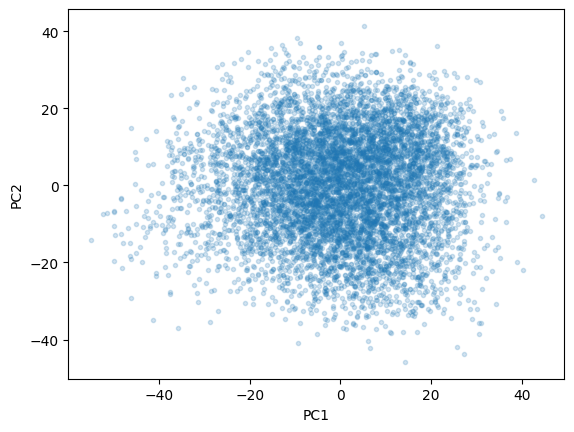

In [236]:
plt.scatter(proj[:, 0], proj[:, 1], marker=".", alpha=0.2)
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0, 0.5, 'TSNE2')

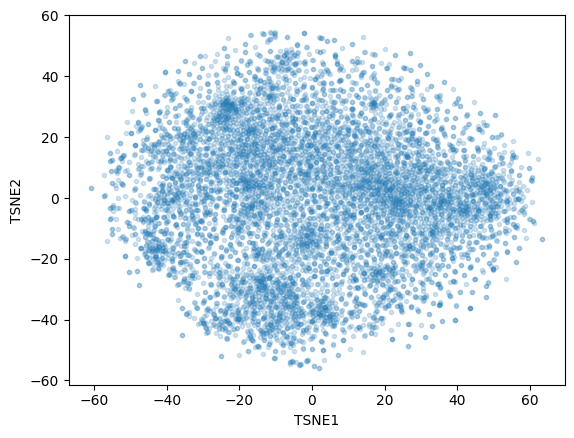

In [237]:
plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], marker=".", alpha=0.2)
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")

Text(0, 0.5, 'TSNE2')

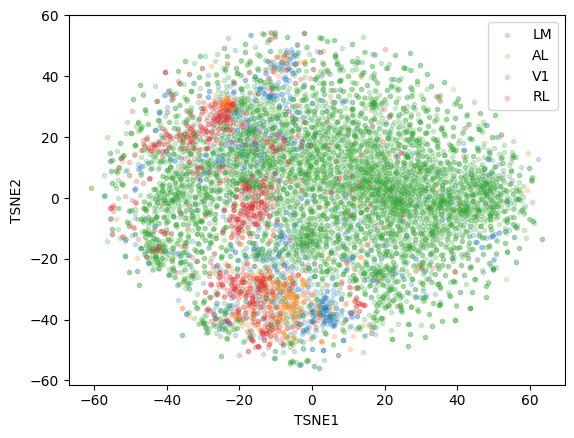

In [238]:
joined = pl.DataFrame(unit_map.reset_index()).join(unit_anatomy_df, on=["session", "scan_idx", "unit_id"], how="left")
for (grp,), piece in joined.group_by("brain_area"):
    ixs = piece["readout_id"].to_numpy()
    plt.scatter(tsne_proj[ixs, 0], tsne_proj[ixs, 1], marker=".", alpha=0.2, label=grp)
    
plt.legend()
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
